In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
import torch.utils.data as D

import torchvision.datasets
import torchvision.transforms as T
import torchvision.models

import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
def img_resize(x):
    x = T.functional.to_tensor(x)
    x = T.functional.resize(x, [256, 256], antialias=False)
    return x

def img_augment(x, y):
    rand = torch.rand(5)
    angle = rand[0].item() * 20 - 10 # +-10 degrees rotation
    offsetx = rand[1].item() * 100 - 50 # +-50 pixel translation
    offsety = rand[2].item() * 100 - 50 # +-50 pixel translation
    scale = 1.0 # rand[3].item() * 0.5 + 0.75 # +-25% scale
    shear = rand[4].item() * 20 - 10 # +-10 degrees shear

    x = img_resize(x)
    y = img_resize(y)
    x = T.functional.pad(x, 128, padding_mode="reflect")
    y = T.functional.pad(y, 128, padding_mode="reflect")

    x = T.functional.affine(x, angle, [offsetx, offsety], scale, shear)
    y = T.functional.affine(y, angle, [offsetx, offsety], scale, shear)
    
    x = T.functional.center_crop(x, 256)
    y = T.functional.center_crop(y, 256)
        
    return x, y

In [17]:
dataset = torchvision.datasets.VOCSegmentation(".", image_set="trainval", download=True, transform=lambda i: img_resize(i), target_transform=lambda i: img_resize(i))
dataset_aug = torchvision.datasets.VOCSegmentation(".", image_set="trainval", download=True, transforms=lambda x, y: img_augment(x, y))
assert(len(dataset) == len(dataset_aug))

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [18]:
batch_size = 4
train_cutoff = int(len(dataset) * 0.9)
train_data = D.DataLoader(D.Subset(dataset_aug, range(train_cutoff)), batch_size=batch_size, num_workers=4)
val_data = D.DataLoader(D.Subset(dataset, range(train_cutoff, len(dataset))), batch_size=batch_size, num_workers=4)

In [7]:
def train(data, model, optimizer):
    losses = []
    model.train()
    for x, y in data:
        x, y = x.to(device), y.to(device)

        pred = model.forward(x)
        loss = model.loss(pred, y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return torch.tensor(losses).mean().item()

In [8]:
@torch.no_grad()
def eval(data, model):
    loss = 0
    model.eval()
    for x, y in data:
        x, y = x.to(device), y.to(device)
        pred = model.forward(x)
        loss += model.loss(pred, y).item()
    return loss / len(data)

In [91]:
def trainloop(model, epochs=5, optimizer=torch.optim.AdamW, verbose=False, **optargs):
    optimizer = optimizer(model.parameters(), **optargs)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    start = time.time()
    train_losses, val_losses = [], []
    for e in range(epochs):
        epoch_start = time.time()
        train_loss = train(train_data, model, optimizer)
        val_loss = eval(val_data, model)
        if verbose:
            print(f"Epoch {e}: {time.time()-epoch_start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}, lr {optimizer.param_groups[0]['lr']}")
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    nparams = sum(p.numel() for p in model.parameters())
    print(f"Train [{nparams/1e6:.3f}M params]: {epochs} epochs took {time.time()-start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()

In [10]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        I.xavier_normal_(m.weight)
        I.constant_(m.bias, 0)

In [80]:
class SegBlock(nn.Module):
    def __init__(self, inc, midc, outc):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(inc, midc, kernel_size=3, padding=1),
            nn.BatchNorm2d(midc),
            nn.ReLU(),
            nn.Conv2d(midc, outc, kernel_size=3, padding=1),
            nn.BatchNorm2d(outc),
            nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)
        
class SegNet(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth

        self.encoder = []
        for i in range(depth):
            self.encoder.append(SegBlock(3 if i == 0 else channels << (i-1), channels << i, channels << i))
            self.encoder.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encoder = nn.ModuleList(self.encoder)

        self.transform = SegBlock(channels << (depth - 1), channels << depth, channels << depth)

        self.decoder = []
        for i in range(depth, 0, -1):
            self.decoder.append(nn.ConvTranspose2d(channels << i, channels << i, kernel_size=2, stride=2))
            # note: between these layers we'll have concat which will double channel count
            self.decoder.append(SegBlock((channels << i) + (channels << (i-1)), channels << (i-1), channels << (i-1)))
        self.decoder = nn.ModuleList(self.decoder)
            
        self.predict = nn.Sequential(
            SegBlock(channels, channels, channels),
            nn.Conv2d(channels, 1, kernel_size=1))
        self.loss = nn.BCELoss() # TODO: DICE or some sort of soft equivalents

        self.apply(weight_init)
        
    # image => image
    def forward(self, x):
        copies = []
        for i in range(self.depth):
            conv, pool = self.encoder[i*2], self.encoder[i*2+1]
            x = conv(x)
            copies.append(x)
            x = pool(x)
            
        x = self.transform(x)
        
        for i in range(self.depth):
            up, conv = self.decoder[i*2], self.decoder[i*2+1]
            x = up(x)
            x = torch.cat((x, copies[-(i+1)]), dim=1)
            x = conv(x)
        
        y = self.predict(x)
        y = F.sigmoid(y)
        return y

Epoch 0: 16.97 sec, train loss 0.243370, val loss 0.266820, lr 0.001
Epoch 1: 15.98 sec, train loss 0.219017, val loss 0.264396, lr 0.001
Epoch 2: 16.58 sec, train loss 0.218403, val loss 0.264844, lr 0.001
Epoch 3: 16.94 sec, train loss 0.215897, val loss 0.258137, lr 0.001
Epoch 4: 16.69 sec, train loss 0.215750, val loss 0.261847, lr 0.001
Epoch 5: 16.24 sec, train loss 0.213613, val loss 0.256555, lr 0.001
Epoch 6: 16.79 sec, train loss 0.210917, val loss 0.254050, lr 0.001
Epoch 7: 16.29 sec, train loss 0.211893, val loss 0.252995, lr 0.001
Epoch 8: 16.90 sec, train loss 0.210076, val loss 0.253166, lr 0.001
Epoch 9: 17.46 sec, train loss 0.209810, val loss 0.251081, lr 0.001
Epoch 10: 16.57 sec, train loss 0.210435, val loss 0.252517, lr 0.001
Epoch 11: 16.13 sec, train loss 0.210227, val loss 0.252954, lr 0.001
Epoch 12: 16.43 sec, train loss 0.208511, val loss 0.251485, lr 0.001
Epoch 13: 16.34 sec, train loss 0.208775, val loss 0.248271, lr 0.001
Epoch 14: 16.20 sec, train los

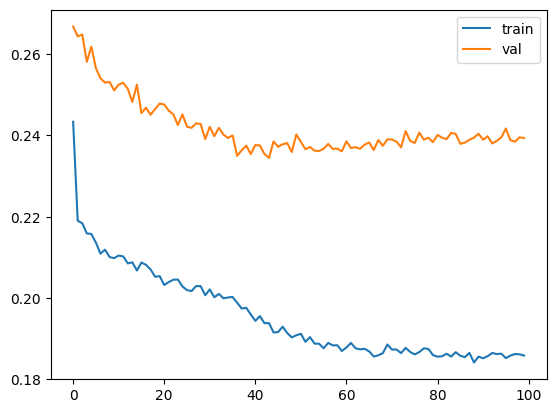

In [92]:
# UNet that loosely follows the architecture from the UNet paper but has slightly different setup
torch.manual_seed(42)
net = SegNet(depth=5, channels=16).to(device)
trainloop(net, epochs=100, weight_decay=0.01, verbose=True)

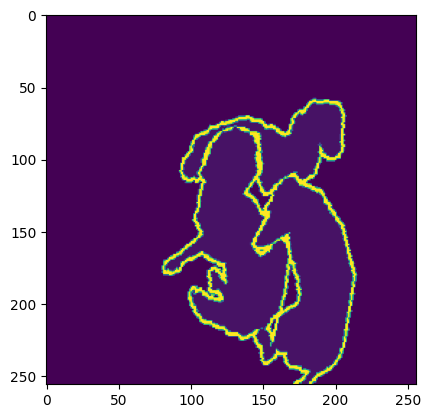

In [82]:
plt.imshow(dataset_aug[71][1].permute(1, 2, 0))

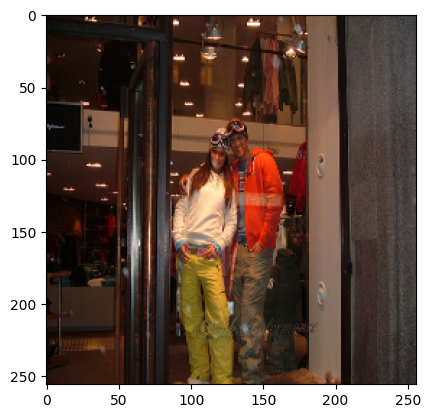

In [101]:
plt.imshow(dataset[-6][0].permute(1, 2, 0))

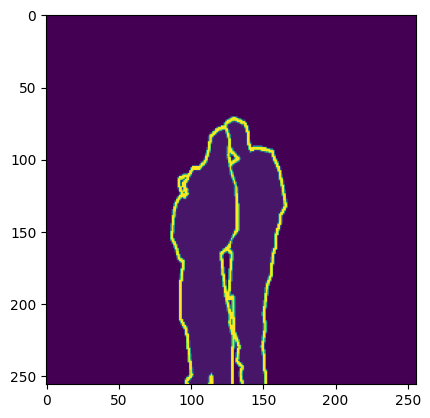

In [97]:
plt.imshow(dataset[-6][1].permute(1, 2, 0))

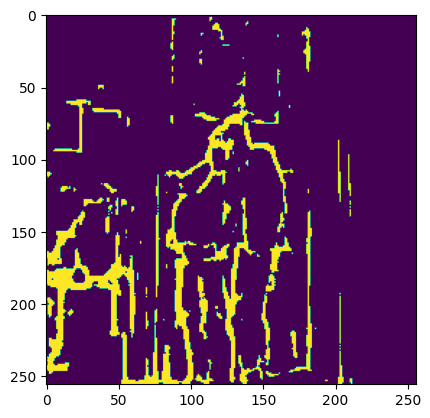

In [100]:
plt.imshow((torch.squeeze(net(torch.unsqueeze(dataset[-6][0].to(device), 0))) > 0.15).float().cpu().detach())

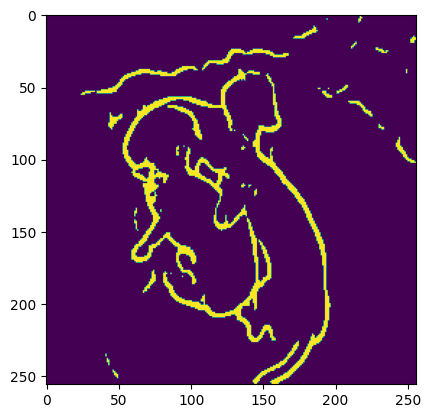

In [93]:
plt.imshow((torch.squeeze(net(torch.unsqueeze(dataset[71][0].to(device), 0))) > 0.2).float().cpu().detach())